# GEOG5990M Final Assignment
Student ID:201838279

## Spatial Data Science Report on Leeds (OA level) Health Vulnerability Classification

### Introduction
Investigating and interpreting open spatial data to reveal hidden patterns in population characteristics is at the heart of modern public‐health planning. By combining publicly available geographic boundaries (e.g., census Output Areas, administrative zones) with demographic and socio-economic indicators, we can classify neighborhoods into meaningful “geodemographic” segments—each with distinct vulnerability profiles. In this project, we harness the power of Python’s data-science and GIS libraries (Pandas, NumPy, GeoPandas, Matplotlib, Seaborn, and scikit-learn) to derive health-vulnerability clusters that will directly inform the equitable allocation of health‐service resources. 

This project workflow is implemented entirely in Python, importing packages:

- **Pandas** for loading, cleaning, and merging tabular data <a href="#ref1">[1]</a>;
- **NumPy** for fast, array‐based numerical operations underpinning standardization and distance computations <a href="#ref2">[2]</a>;
- **GeoPandas** for handling geospatial data as GeoDataFrames and performing spatial joins <a href="#ref3">[3]</a>;
- **Matplotlib** for creating static visualizations such as the elbow‐plot and static cluster maps <a href="#ref4">[4]</a>;
- **Seaborn** for enhanced statistical plotting during exploratory data analysis <a href="#ref5">[5]</a>;
- **scikit-learn** for the core K-means algorithm <a href="#ref6">[6]</a>.


In [5]:
# import required packages
import geopandas as gpd
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

import matplotlib.pyplot as plt

# import the required machine learning packages
from sklearn import cluster
from sklearn.preprocessing import scale

# set seaborn plotting theme to white
sns.set_theme(style="white")

### Data Overview

The population characteristics data were collected from Uk Census Data 2011 from website: https://www.ons.gov.uk/census/2011census/2011censusdata. Overall, seven variables were chosen considering the health vulnerability for example percentage of households occupied by lone parent and children, person who report long term poor health, occupational health risk families, old aged person, person living in crowded area and language barriers etc.

Data were loaded and some initial analysis were performed to get information about data type, number of nulls and total columns.


In [8]:
#read data
data = pd.read_csv('https://github.com/taslima432/GEOG5990M/raw/refs/heads/main/Leeds_variables.csv')

In [10]:
#data informations like number of missing data ,data type to decide if any processing needed
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2543 entries, 0 to 2542
Data columns (total 8 columns):
 #   Column                                                                                             Non-Null Count  Dtype  
---  ------                                                                                             --------------  -----  
 0   OA                                                                                                 2543 non-null   object 
 1   Households_occupied_by_a_lone_parent_and_children                                                  2543 non-null   float64
 2   Persons_who_report_poor_health_Limiting_long-term_illness                                          2543 non-null   float64
 3   Employed_persons_aged_ between_16_and_74_who_work_in_the_mining/quarrying/construction_industries  2543 non-null   float64
 4   Person_aged_90_and_over                                                                            2543 non-null   float6

### Data Pre-processing
Initial data analyis reveals that there is no missing data and data type is well defined for every variables so no data cleaning was needed. data.head() shows first few data of each colums which shows data type is also correctly interpretated.

In [12]:
# Checking data type
data.head()

OA  Households_occupied_by_a_lone_parent_and_children  \
0  E00056750                                           6.382979   
1  E00056751                                           7.272727   
2  E00056752                                           5.000000   
3  E00056753                                           0.000000   
4  E00056754                                           4.580153   

   Persons_who_report_poor_health_Limiting_long-term_illness  \
0                                               8.24           
1                                               2.36           
2                                               6.14           
3                                              23.17           
4                                               0.74           

   Employed_persons_aged_ between_16_and_74_who_work_in_the_mining/quarrying/construction_industries  \
0                                               7.74                                                   
1                                              10.78                                                   
2                                               8.41                                                   
3                                               6.74                                                   
4                                               6.13                                                   

   Person_aged_90_and_over  Persons_living_in_a_communal_establishment  \
0                     0.72                                        0.72   
1                     0.34                                        0.00   
2                     0.74                                        0.00   
3                     5.28                                       12.60   
4                     0.00                                        0.00   

   Households_who_have_one_fewer_or_less_rooms_than_required  \
0                                               3.55           
1                                               2.73           
2                                               2.00           
3                                               9.93           
4                                               4.58           

   Persons_whose_main_language_is_not_English_and_they_cannot_speak_English_well_or_at all  
0                                               0.36                                        
1                                               0.00                                        
2                                               0.25                                        
3                                               0.41                                        
4                                               1.47

In [9]:
#Checking all variables
data.columns


Index(['OA', 'Households_occupied_by_a_lone_parent_and_children',
       'Persons_who_report_poor_health_Limiting_long-term_illness',
       'Employed_persons_aged_ between_16_and_74_who_work_in_the_mining/quarrying/construction_industries',
       'Person_aged_90_and_over', 'Persons_living_in_a_communal_establishment',
       'Households_who_have_one_fewer_or_less_rooms_than_required',
       'Persons_whose_main_language_is_not_English_and_they_cannot_speak_English_well_or_at all'],
      dtype='object')

### Data Visualisation
The variables used for the project were visualised to see if any processing required which was not identical without visualisation. Using boxplot to check for distributional quirks—even though all are percentages, their ranges vary greatly, so standardisation was essential before clustering. 

<Axes: >

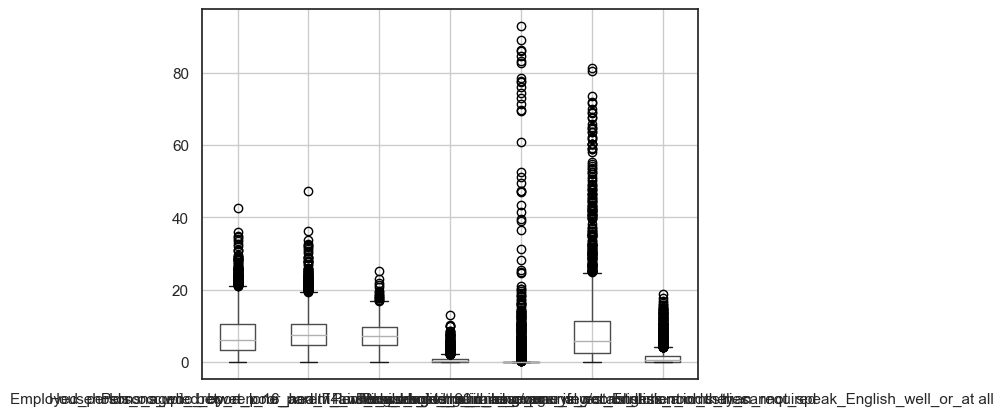

In [14]:
#boxplotting
data.boxplot(column=['Households_occupied_by_a_lone_parent_and_children', 'Persons_who_report_poor_health_Limiting_long-term_illness', 'Employed_persons_aged_ between_16_and_74_who_work_in_the_mining/quarrying/construction_industries', 'Person_aged_90_and_over', 'Persons_living_in_a_communal_establishment', 'Households_who_have_one_fewer_or_less_rooms_than_required', 'Persons_whose_main_language_is_not_English_and_they_cannot_speak_English_well_or_at all'] )

### Standardisation or Z-score
Standardisation of the data was required before doing k-means clustering. Standardisation is the central preprocessing step in data mining, bring each feature to a common scale, preventing any single variable from dominating the Euclidean-distance calculations at K-means’ core <a href="#ref7">[7]</a>. 


In [16]:
# assume `data` is your DataFrame, and cols is the list of your 7 indicator names
cols = data.columns[1:8]  

# Z-score in-place
data[cols] = data[cols].apply(lambda x: (x - x.mean()) / x.std())
data

OA  Households_occupied_by_a_lone_parent_and_children  \
0     E00056750                                          -0.213656   
1     E00056751                                          -0.067664   
2     E00056752                                          -0.440578   
3     E00056753                                          -1.260987   
4     E00056754                                          -0.509467   
...         ...                                                ...   
2538  E00170623                                           0.283313   
2539  E00170887                                           0.172738   
2540  E00170888                                          -0.836637   
2541  E00170889                                          -0.850782   
2542  E00170890                                          -0.134935   

      Persons_who_report_poor_health_Limiting_long-term_illness  \
0                                             -0.006533           
1                                             -1.132874           
2                                             -0.408798           
3                                              2.853377           
4                                             -1.443193           
...                                                 ...           
2538                                          -1.330175           
2539                                          -0.770836           
2540                                          -1.301442           
2541                                          -0.077408           
2542                                          -1.314851           

      Employed_persons_aged_ between_16_and_74_who_work_in_the_mining/quarrying/construction_industries  \
0                                              0.147506                                                   
1                                              0.992737                                                   
2                                              0.333790                                                   
3                                             -0.130531                                                   
4                                             -0.300133                                                   
...                                                 ...                                                   
2538                                          -0.283451                                                   
2539                                           0.258721                                                   
2540                                          -1.123121                                                   
2541                                          -0.255647                                                   
2542                                          -1.089757                                                   

      Person_aged_90_and_over  Persons_living_in_a_communal_establishment  \
0                    0.009520                                   -0.083541   
1                   -0.316585                                   -0.179797   
2                    0.026683                                   -0.179797   
3                    3.922782                                    1.504687   
4                   -0.608364                                   -0.179797   
...                       ...                                         ...   
2538                -0.608364                                   -0.179797   
2539                -0.608364                                   -0.179797   
2540                -0.608364                                   -0.179797   
2541                 1.133724                                   -0.179797   
2542                -0.608364                                   -0.179797   

      Households_who_have_one_fewer_or_less_rooms_than_required  \
0                                             -0.502449           
1                      

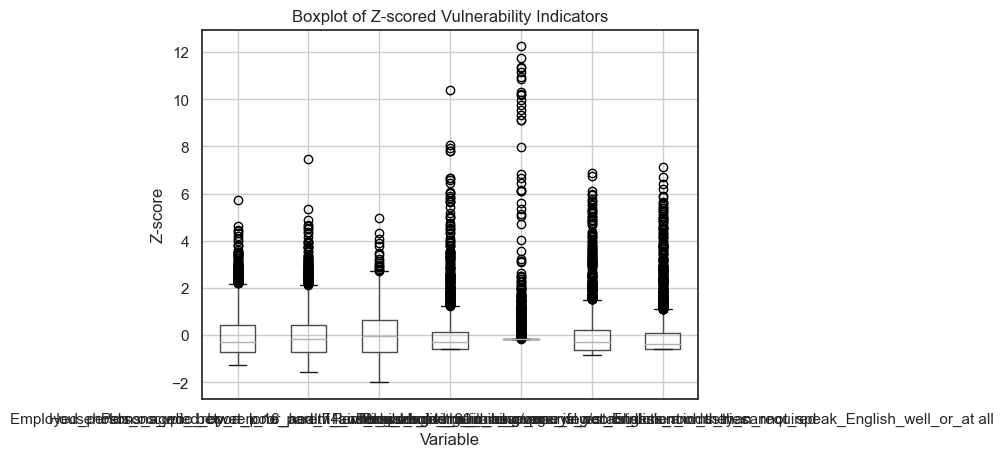

In [18]:
# Boxplot of the standardized indicators
data[cols].boxplot()
plt.title('Boxplot of Z-scored Vulnerability Indicators')
plt.ylabel('Z-score')
plt.xlabel('Variable')
plt.show()

### K-means Clustering
K-means clustering is particularly well suited for this task because it is an efficient, unsupervised method that partitions multivariate data into k compact, centroid-based clusters, facilitating interpretable geodemographic segmentation without preexisting labels <a href="#ref8">[8]</a>. The Euclidean‐distance criterion of K-means aligns naturally with Z-score–standardized vulnerability indicators, ensuring each variable contributes equally to the cluster formation <a href="#ref6">[6]</a>. We determine the optimal number of clusters via the “elbow method,” balancing within‐cluster cohesion against model complexity.

The number of clusters was decided to be k=4 from the **Elbow Method**.

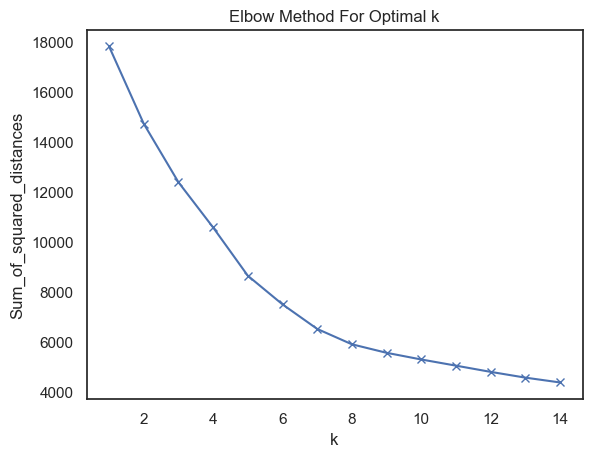

In [21]:
# create an empty list to fill with values later
Sum_of_squared_distances = []

# get a range of numbers from 1 to 15
K = range(1,15)
#for each number in the range 1 to 15
for k in K:
    # create a k-means model with that number of clusters
    # set random state
    km = cluster.KMeans(n_clusters=k,
        init='k-means++',    # smart initialization
        n_init=10,           # number of re-starts to reduce chance of a bad seed
        random_state=42)
    # fit the model using the variables of interest (in this case the 7 PPFI domain deciles)
    km = km.fit(data[['Households_occupied_by_a_lone_parent_and_children',
       'Persons_who_report_poor_health_Limiting_long-term_illness',
       'Employed_persons_aged_ between_16_and_74_who_work_in_the_mining/quarrying/construction_industries',
       'Person_aged_90_and_over', 'Persons_living_in_a_communal_establishment',
       'Households_who_have_one_fewer_or_less_rooms_than_required',
       'Persons_whose_main_language_is_not_English_and_they_cannot_speak_English_well_or_at all']].values)
    # calculate the sum of the squared distances and add this to the 'Sum_of_squared_distances' list we created earlier
    Sum_of_squared_distances.append(km.inertia_)

# plot the sum of squared distances against the number of clusters
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show();

In [23]:
# run the model with 4 clusters
km4= cluster.KMeans(n_clusters=4,init="random", random_state=123)
km4cls = km4.fit(data[['Households_occupied_by_a_lone_parent_and_children',
       'Persons_who_report_poor_health_Limiting_long-term_illness',
       'Employed_persons_aged_ between_16_and_74_who_work_in_the_mining/quarrying/construction_industries',
       'Person_aged_90_and_over', 'Persons_living_in_a_communal_establishment',
       'Households_who_have_one_fewer_or_less_rooms_than_required',
       'Persons_whose_main_language_is_not_English_and_they_cannot_speak_English_well_or_at all']].values)


C:\Software\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [25]:
# let's look at the cluster labels (each OA has been assigned a cluster in this array)
km4cls.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
# let's look at the cluster labels (each LSOA has been assigned a cluster in this array)

data['Cluster'] = km4cls.labels_
data['Cluster'].head()

0    1
1    1
2    1
3    0
4    1
Name: Cluster, dtype: int32

In [29]:
# The pair plot gives us an idea of all the relationships between the domains captured by the clustering
sns.pairplot(data[['Households_occupied_by_a_lone_parent_and_children',
       'Persons_who_report_poor_health_Limiting_long-term_illness',
       'Employed_persons_aged_ between_16_and_74_who_work_in_the_mining/quarrying/construction_industries',
       'Person_aged_90_and_over', 'Persons_living_in_a_communal_establishment',
       'Households_who_have_one_fewer_or_less_rooms_than_required',
       'Persons_whose_main_language_is_not_English_and_they_cannot_speak_English_well_or_at all','Cluster']],
             hue='Cluster',
             palette='Dark2',
            height=5)

In [29]:
#use groupby to get the median decile value of each PPFI domain by cluster
data_clusters_median=data.groupby('Cluster')[['Households_occupied_by_a_lone_parent_and_children',
       'Persons_who_report_poor_health_Limiting_long-term_illness',
       'Employed_persons_aged_ between_16_and_74_who_work_in_the_mining/quarrying/construction_industries',
       'Person_aged_90_and_over', 'Persons_living_in_a_communal_establishment',
       'Households_who_have_one_fewer_or_less_rooms_than_required',
       'Persons_whose_main_language_is_not_English_and_they_cannot_speak_English_well_or_at all']].median().reset_index()

In [31]:
data_clusters_median

Cluster  Households_occupied_by_a_lone_parent_and_children  \
0        0                                          -0.455647   
1        1                                          -0.403843   
2        2                                          -1.048796   
3        3                                           1.253170   

   Persons_who_report_poor_health_Limiting_long-term_illness  \
0                                           2.060341           
1                                          -0.343669           
2                                          -1.210454           
3                                           0.092118           

   Employed_persons_aged_ between_16_and_74_who_work_in_the_mining/quarrying/construction_industries  \
0                                          -0.052680                                                   
1                                           0.214235                                                   
2                                          -1.513763                                                   
3                                          -0.497539                                                   

   Person_aged_90_and_over  Persons_living_in_a_communal_establishment  \
0                 2.026223                                   -0.179797   
1                -0.299422                                   -0.179797   
2                -0.608364                                   -0.179797   
3                -0.423857                                   -0.179797   

   Households_who_have_one_fewer_or_less_rooms_than_required  \
0                                          -0.182528           
1                                          -0.521379           
2                                           2.941430           
3                                           0.322908           

   Persons_whose_main_language_is_not_English_and_they_cannot_speak_English_well_or_at all  
0                                          -0.416623                                        
1                                          -0.455876                                        
2                                          -0.183166                                        
3                                           0.668023

In [2]:
# let's transform the data from a 'wide' format to a 'long' format to plot
data_clusters_median_to_plot =pd.melt(data_clusters_median,id_vars='Cluster',
                                            value_vars=['Households_occupied_by_a_lone_parent_and_children',
       'Persons_who_report_poor_health_Limiting_long-term_illness',
       'Employed_persons_aged_ between_16_and_74_who_work_in_the_mining/quarrying/construction_industries',
       'Person_aged_90_and_over', 'Persons_living_in_a_communal_establishment',
       'Households_who_have_one_fewer_or_less_rooms_than_required',
       'Persons_whose_main_language_is_not_English_and_they_cannot_speak_English_well_or_at all'])
# check what the data now look like
data_clusters_median_to_plot.head()

NameError: name 'pd' is not defined

In [35]:
data_clusters_median_to_plot.columns = ['Cluster','Factors','Median decile']
data_clusters_median_to_plot.head()

Cluster                                            Factors  Median decile
0        0  Households_occupied_by_a_lone_parent_and_children      -0.455647
1        1  Households_occupied_by_a_lone_parent_and_children      -0.403843
2        2  Households_occupied_by_a_lone_parent_and_children      -1.048796
3        3  Households_occupied_by_a_lone_parent_and_children       1.253170
4        0  Persons_who_report_poor_health_Limiting_long-t...       2.060341

In [37]:
# Plot a faceted bar chart, where each row is a different cluster

sns.catplot(data_clusters_median_to_plot,
            row='Cluster',
            y='Factors',
            x='Median decile',
            kind='bar',
            height =6,
            aspect = 3,
            dodge = False,
            hue='Median decile',
            palette='colorblind')
plt.savefig('cluster_domains_overview.png')

### Analysis
From the output bar chart the cluster characteristics or dominant features can be seen. According to the cluster domain overview the domain classes were assigned as 'Vulnerable Age Group with Health Challenges', 'Occupationa; Health Risk Families', 'Overcrowed and Communal Living' and 'Disadvantaged Familis' for cluster 0 to 3, respectively.

In [39]:
# create empty column
data['Cluster_description']=""
#edit to add your cluster descriptions
data.loc[data['Cluster']==0,'Cluster_description']='Vulnerable Age Group with Health Challenges'
data.loc[data['Cluster']==1,'Cluster_description']='Occupational Health Risk Families'
data.loc[data['Cluster']==2,'Cluster_description']='Overcrowded and Communal Living'
data.loc[data['Cluster']==3,'Cluster_description']='Disadvantaged Families'


### Joining Spatial Data
After spatial modelling and deriving cluster classes, the attribute data were joined with Leeds OA level spatial data in .json file. The CRS was chaned to British National Grid and merged to the attribute data.

In [41]:
import matplotlib.pyplot as plt
import contextily as ctx
# URL to the GeoJSON file for Leeds Output Area Classification
geojson_url = "https://martinjc.github.io/UK-GeoJSON/json/eng/oa_by_lad/topo_E08000035.json"      #chatgpt prompt: create url for leeds output area classification shapefile

# Load the GeoJSON file from the URL
leeds = gpd.read_file(geojson_url)
leeds.set_crs(epsg=4326, inplace=True, allow_override=True) #defining CRS
# Convert CRS to British National Grid (EPSG:27700)
leeds_proj = leeds.to_crs(epsg=27700)
# Merge spatial data with attribute data based on common column 'OA11CD' and 'output_area'
leeds_merged = leeds_proj.merge(data,left_on='OA11CD', 
                                right_on='OA')



In [ ]:
leeds_merged.head()

### Health Vulnerability Cluster Map
Merged data were visualised using cluster description as legend. Color palette was chosen considering color-blind friendly visualisation. From the map, it is evident that most of the area falls under "Occupational Health Risk Families". The 'Vulnerable Age Group with Health Challenges'class is scattered all over the area on the other hand 'Overcrowded and Communal Living'and 'Disadvantaged Families' classes exist in the central zone of the area.

In [42]:
# Plot your cluster descriptions on the map
# use hex colours to define my own cmap,
# cbind friendly palette colours taken from: https://davidmathlogic.com/colorblind/#%23648FFF-%23785EF0-%23DC267F-%23FE6100-%23FFB000
my_cmap=['#FFB000','#785EF0','#DC267F','#FE6100']
map =leeds_merged.sort_values('Cluster_description').explore('Cluster_description', categorical =True, cmap=my_cmap)

# save to html file
map.save("leeds_health_vulnerability_cluster_map.html")

# view map
map

### Recommendations
- Mobile clinics in 'Vulnerable Age Group with Health Challenges'.
- Outreach to 'Disadvantaged Families'.
- Occupational screenings for 'Occupational Health-Risk Families.
- Housing improvement initiatives in 'Overcrowded and Communal Living'.

### Acknowledgement
I acknowledge the use of ChatGPT-4o (Open AI, https://chat.openai.com/) to support development of code to generate legend headings and support formatting of figures and to support debugging errors as identified in the code, Prompt: Help debug this error {ERROR MESSAGE} generated while using the imported packages”
### References
<p><a href="https://doi.org/10.25080/Majora-92bf1922-00a">[1]</a>McKinney, W. Data Structures for Statistical Computing in Python. In: 2010, pp.56-61.</p>
<p><a href="https://github.com/FrancescaPontin/GEOG5990">[2]</a>Oliphant, T.E. A Guide to NumPy.  Trelgol Publishing, 2006.</p>
<p><a href="https://doi.org/10.5281/zenodo.12625316">[3]</a>Zenodo. geopandas/geopandas: v1.0.1. (v1.0.1).[Software].2024. [Accessed 30 April 2025].</p>
<p><a href="https://doi.org/10.1109/MCSE.2007.55">[4]</a>Hunter, J.D. Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering. [Online]. 2007, 9(3), pp.90-95. [Accessed 30 April 2025]. Available from: https://doi.org/10.1109/MCSE.2007.55 </p>
<p><a href="https://doi.org/10.21105/joss.03021">[5]</a>Waskom, M.L. seaborn: statistical data visualization. Journal of Open Source Software. [Online]. 2021, 6(60), p.3021. [Accessed 30 April 2025]. Available from: https://doi.org/10.21105/joss.03021 </p>
<p><a href="https://dl.acm.org/doi/10.5555/1953048.2078195">[6]</a>Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M. and Duchesnay, É. Scikit-learn: Machine Learning in Python. J. Mach. Learn. Res. [Online]. 2011, 12(null), pp.2825–2830. Available from: https://dl.acm.org/doi/10.5555/1953048.2078195</p>
<p><a href="https://doi.org/10.19026/rjaset.6.3638 ">[6]</a>Mohamad, I. and Usman, D. Standardization and Its Effects on K-Means Clustering Algorithm. Research Journal of Applied Sciences, Engineering and Technology. [Online]. 2013, 6, pp.3299-3303. [Accessed 2 May 2025]. Available from: https://doi.org/10.19026/rjaset.6.3638 </p>
<p><a href="https://www.mdpi.com/1660-4601/10/6/2578">[8]</a>Shi, W. and Zeng, W. Genetic k-Means Clustering Approach for Mapping Human Vulnerability to Chemical Hazards in the Industrialized City: A Case Study of Shanghai, China. International Journal of Environmental Research and Public Health. [Online]. 2013, 10(6), pp.2578-2595. Available from: https://www.mdpi.com/1660-4601/10/6/2578</p>

